In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import torch
from torchvision import transforms


/home/olofnuggets/Desktop/hk34/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

dataset=  load_dataset("ILSVRC/imagenet-1k", split="train", streaming=True)

In [ ]:
small_dataset =  dataset.take(1000) # type: ignore

# 1. Define a transform to force all images to the same size
# This is mandatory for batching!
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize everything to 224x224
    transforms.ToTensor()
])

# 2. Helper function to process the batch "on the fly"
def collate_fn(batch) -> tuple[torch.Tensor, torch.Tensor]:
    # 'batch' is a list of dictionaries from the dataset
    images = []
    labels = []
    
    for item in batch:
        # Transform the image (ensure it's RGB)
        img = item['image'].convert("RGB")
        images.append(transform(img))
        labels.append(item['label'])
    
    # Stack them into single Tensors
    return torch.stack(images), torch.tensor(labels)

# 3. Create DataLoader with the custom collate function
dataloader = DataLoader(small_dataset, batch_size=32, collate_fn=collate_fn) # type: ignore

print("Downloading and processing batch... (this takes time)")
data_iter = iter(dataloader)
images, labels = next(data_iter)
                                    #               batch_size, channels, height, width
print(f"Batch Shape: {images.shape}") # Should be [32, 3, 224, 224]

Batch Shape: torch.Size([32, 3, 224, 224])


In [16]:
class_names = dataset.features['label'].names  # type: ignore
print(f"Class names: {class_names[:5]}", end="\n")  # Print first 5 class names

index = 0
for name in class_names:
    if name.startswith("cat"):
        print(f"Found class name starting with 'dog': {name, index}")
    index += 1

Class names: ['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark']
Found class name starting with 'dog': ('catamaran', 484)


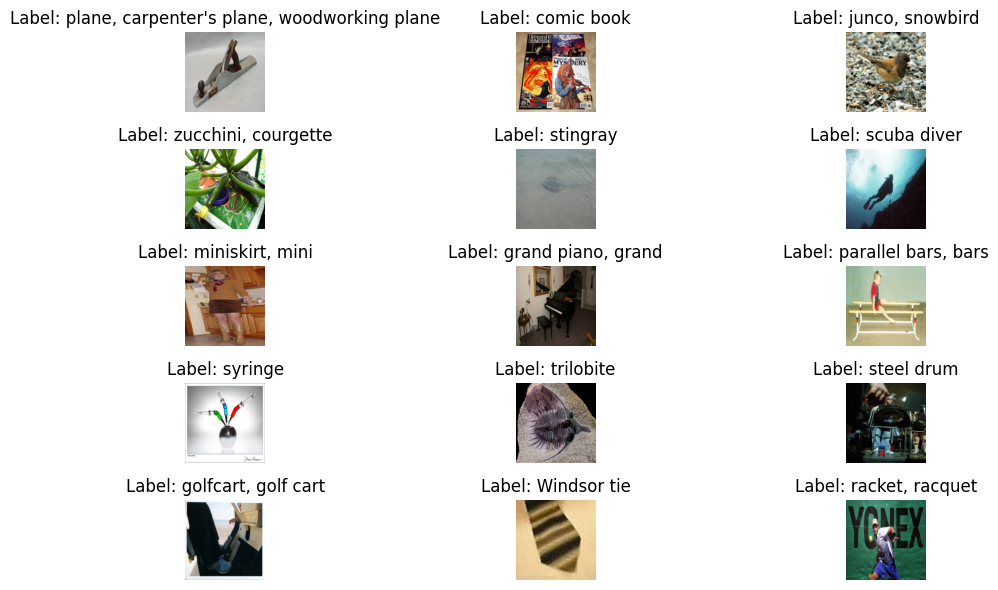

In [11]:
import matplotlib.pyplot as plt

# Create a figure with a grid
fig = plt.figure(figsize=(12, 6))
rows, cols = 5, 3
class_names = dataset.features['label'].names  # type: ignore
for i in range(rows * cols):
    # 1. Add a subplot
    ax = fig.add_subplot(rows, cols, i+1)
    
    # 2. Get the image and remove it from the GPU (if it's there)
    img = images[i].cpu()
    
    # 3. Swap dimensions: (3, 224, 224) -> (224, 224, 3)
    img = img.permute(1, 2, 0)
    
    # 4. Display
    ax.imshow(img)
    ax.set_title(f"Label: {class_names[labels[i].item()]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Access the list of 1000 class names
class_names = dataset.features['label'].names # type: ignore

# Define our target keywords
targets = ['dog', 'cat', 'mouse', 'retriever', 'terrier', 'tabby']

# Find all IDs where the name contains one of our targets
target_ids = []
for idx, name in enumerate(class_names):
    if any(t in name.lower() for t in targets):
        target_ids.append(idx)
        # Optional: Print to see what we found
        # print(f"Found ID {idx}: {name}")

print(f"Found {len(target_ids)} classes matching your animals.")

Found 61 classes matching your animals.


In [14]:
# Define the filter function
def is_target_animal(example):
    return example['label'] in target_ids

# Apply filter
# This doesn't download anything yet! It just sets up the rule.
filtered_dataset = dataset.filter(is_target_animal)

# Use this new filtered_dataset in your loader
# Remember to use the collate_fn and transform from before!
dataloader = DataLoader(filtered_dataset, batch_size=32, collate_fn=collate_fn) # type: ignore

In [15]:
import matplotlib.pyplot as plt

# 1. Get the list of names so we can print "Beagle" instead of "162"
class_names = dataset.features['label'].names # type: ignore

print("Searching the stream for animals... (this might take a moment)")

# 2. Get the next batch from the FILTERED loader
# Note: We reuse the dataloader we created in the previous step
data_iter = iter(dataloader)
images, labels = next(data_iter)

# 3. Plot them
fig = plt.figure(figsize=(15, 8))
rows, cols = 4, 8 # Show all 32 images in a grid

for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i+1)
    
    # Get image and move to CPU
    img = images[i].cpu()
    
    # Swap dimensions for plotting: (Channels, H, W) -> (H, W, Channels)
    img = img.permute(1, 2, 0)
    
    # Get the text name for the label
    label_id = labels[i].item()
    label_name = class_names[label_id].split(',')[0] # Take just the first name (e.g. "tabby" from "tabby, cat")
    
    ax.imshow(img)
    ax.set_title(label_name, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

Searching the stream for animals... (this might take a moment)


AttributeError: 'dict' object has no attribute 'convert'